<div align="center">

# **Table of Contents**

</div>

* **[Introduction](#introduction)**
* **[Importing Necessary Libraries](#import-necessary-libraries)**
* **[Data Loading](#data-loading)**
* **[Data Cleaning](#data-cleaning)**
* **[Exploratory Data Analysis (EDA)](#exploratory-data-analysis)**
    - [Price Movement Over Time](#price-movement-over-time)
    - [Correlation Analysis](#correlation-analysis)
    - [Statistical Summary](#statistical-summary)

* **[Data Preprocessing](#data-preprocessing)**
    - [Handling Missing Values](#handling-missing-values)
    - [Normalization](#Normalization)
    - [Target Definition: Future Price Change](#target-definition:-future-price-change)
    - [Sequence Creation](#sequence-creation)
    - [Splitting Data](#splitting-data)

* **[Model Architecture](#model-architecture)**
    - [Define Hyperparameters](#define-hyperparameters)
    - [Build the Models](#build-the-models)
    - [Compile the Models](#compile-the-models)
    - [Model Summaries](#model-summaries)

* **[Training Models](#training-models)**
    - [Train RNN model](#train-rNN-model)
    - [Train GRU model](#train-gRU-model)
    - [Train LSTM model](#train-lSTM-model)

* **[Evaluation and Visualization](#evaluation-and-visualization)**
    - [Prediction and Evaluation](#prediction-and-evaluation)
    - [Prediction vs Actual Comparison](#prediction-vs-actual-comparison)
    - [Error Trend](#error-trend)

## **Introduction**

In this task, we aim to develop a **Recurrent Neural Network (RNN)** model that forecasts future Bitcoin price trends using historical market data in the form of OHLCV (Open, High, Low, Close, Volume).

This project is part of the Data Science Project for University of Tehran students and focuses on modeling **time series data**. RNNs are specifically designed to handle sequential input, making them well-suited for capturing **temporal dependencies** in financial datasets like cryptocurrency markets.


The dataset includes the following features:

| Column Name | Description                                   |
| ----------- | --------------------------------------------- |
| `Date`      | Date of the record (YYYY-MM-DD)               |
| `Open`      | Price at market open                          |
| `High`      | Highest price during the day                  |
| `Low`       | Lowest price during the day                   |
| `Close`     | Price at market close                         |
| `Volume`    | Number of Bitcoin units traded during the day |

In the following sections, we will explore the data, engineer a meaningful target, and model the historical price behavior using RNNs to make forward-looking predictions.

## **Import Necessary Libraries**

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

## **Data Loading**

In [27]:
path_to_dataset_folder = 'content'
df = pd.read_csv(os.path.join(path_to_dataset_folder, 'BTC-USD.csv'))

print("Bitcoin OHLCV Data Preview:")
display(df.head())

print(f"Dataset shape: {df.shape}")
print(df.dtypes)

Bitcoin OHLCV Data Preview:


,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


Dataset shape: (3222, 7)
Unnamed: 0      int64
Date           object
Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
dtype: object


## **Data Cleaning**

Before proceeding with analysis and modeling, we clean the dataset to ensure it is properly structured for time series forecasting.

The following steps are performed:

* **Remove redundant index column**: The dataset includes a column named `Unnamed: 0`, which is an artifact of saving the DataFrame with the index and serves no analytical purpose.
* **Convert `Date` column to datetime**: The `Date` values are currently stored as strings. We convert them to `datetime` objects to enable chronological sorting and time-based operations.



In [28]:
df.drop(columns=['Unnamed: 0'], inplace=True)

df['Date'] = pd.to_datetime(df['Date'])

print("Data types after cleaning:")
print(df.dtypes)

Data types after cleaning:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


## **Exploratory Data Analysis**

### Price Movement Over Time

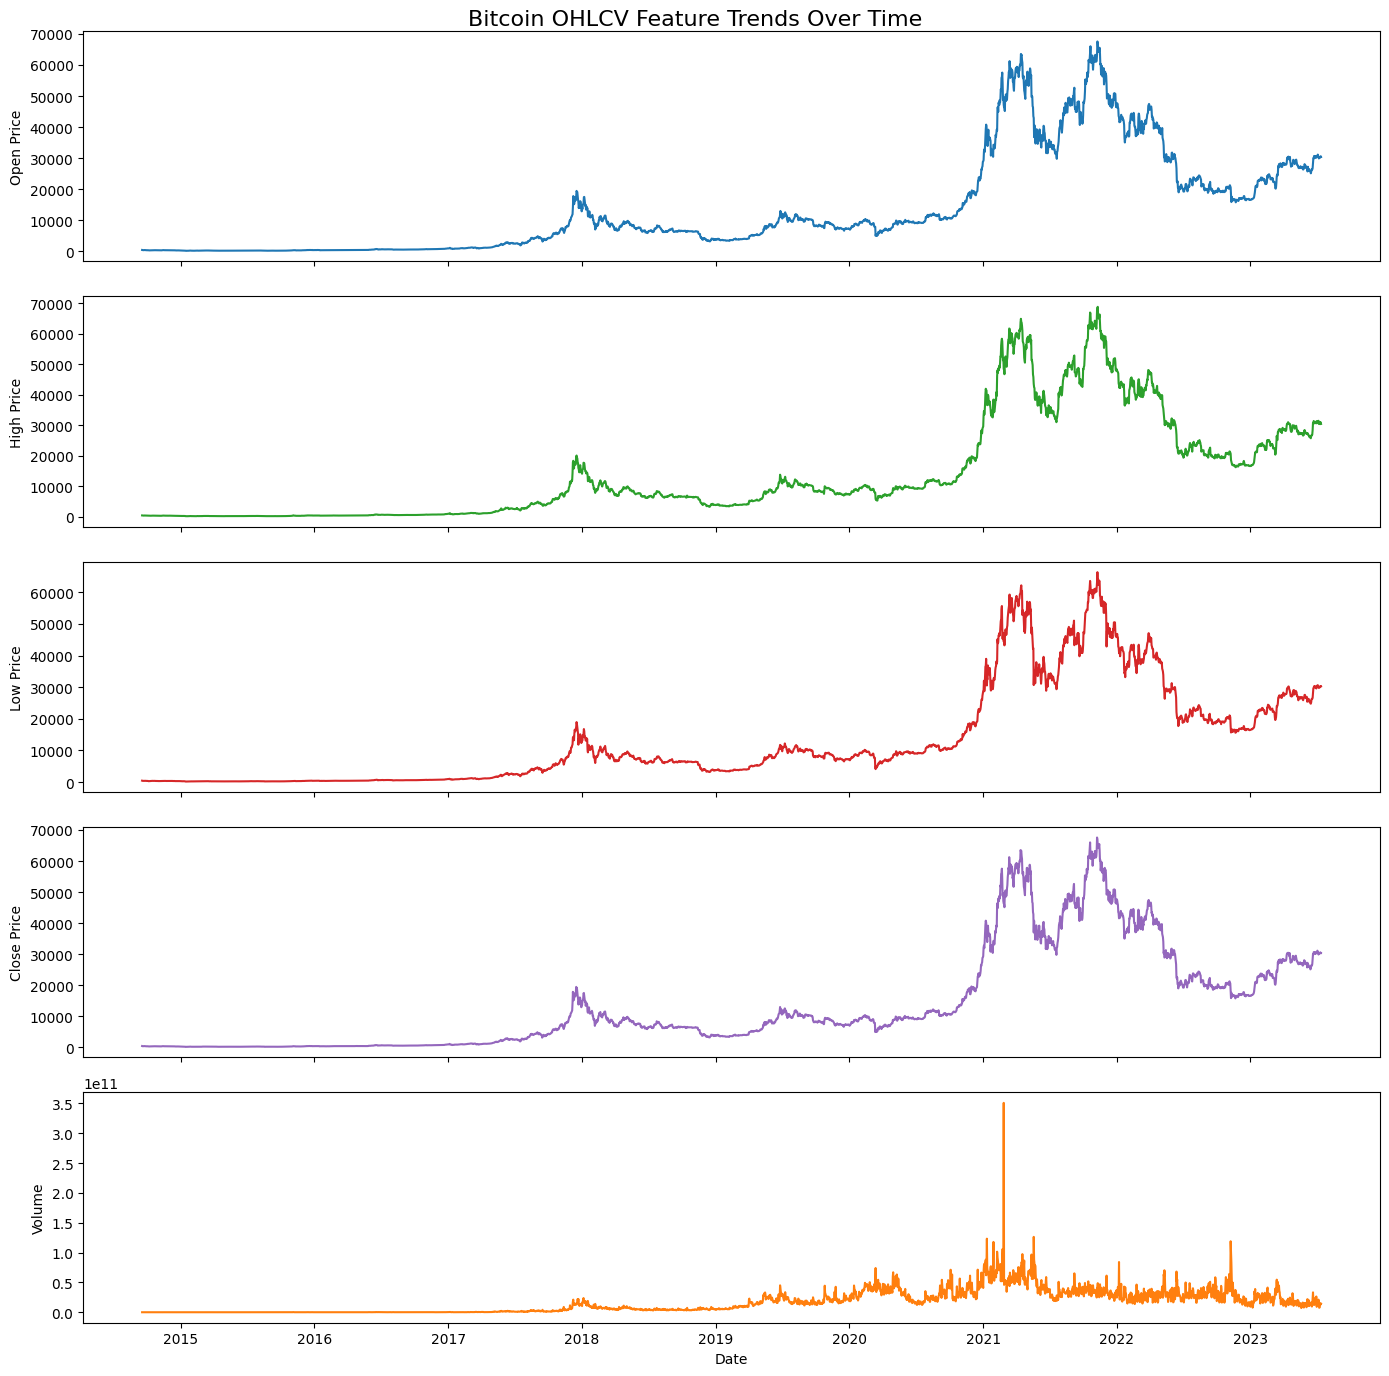

In [29]:
fig, axs = plt.subplots(5, 1, figsize=(14, 14), sharex=True)
fig.suptitle('Bitcoin OHLCV Feature Trends Over Time', fontsize=16)

axs[0].plot(df['Date'], df['Open'], color='tab:blue')
axs[0].set_ylabel('Open Price')

axs[1].plot(df['Date'], df['High'], color='tab:green')
axs[1].set_ylabel('High Price')

axs[2].plot(df['Date'], df['Low'], color='tab:red')
axs[2].set_ylabel('Low Price')

axs[3].plot(df['Date'], df['Close'], color='tab:purple')
axs[3].set_ylabel('Close Price')

axs[4].plot(df['Date'], df['Volume'], color='tab:orange')
axs[4].set_ylabel('Volume')
axs[4].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Correlation Analysis

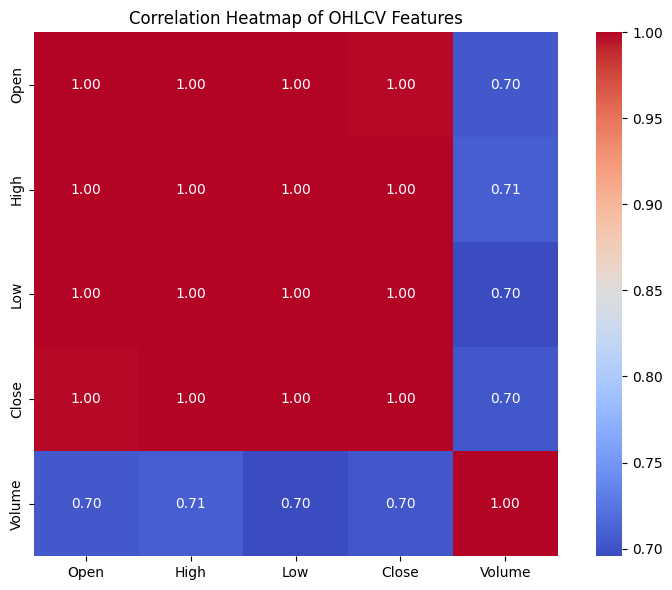

In [30]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

corr = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of OHLCV Features')
plt.tight_layout()
plt.show()

### Statistical Summary

In [31]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,3222,2019-02-13 11:59:59.999999744,2014-09-17 00:00:00,2016-11-30 06:00:00,2019-02-13 12:00:00,2021-04-28 18:00:00,2023-07-13 00:00:00,NaN
Open,3222.0,13633.555524,176.897003,757.83873,7664.044434,20210.792481,67549.734375,16016.59331
High,3222.0,13966.498897,211.731003,772.024277,7867.845215,20660.277832,68789.625,16417.423832
Low,3222.0,13269.790975,171.509995,745.732499,7499.634766,19811.524414,66382.0625,15559.562019
Close,3222.0,13641.491658,178.102997,759.97026,7679.053711,20238.632813,67566.828125,16014.439
Volume,3222.0,16570616998.125387,5914570.0,130048500.0,10175021401.5,27463420005.5,350967941479.0,19507013680.676067


**Key Insights:**

* the **OHLC features** are highly correlated with each other, and they all show a moderate positive correlation (~0.7) with **Volume** — which suggests that while trading activity affects price movement, it's not a perfect predictor.
* The **OHLC features** are in similar ranges and exhibit **very high standard deviations**, indicating high volatility typical of cryptocurrency markets.
* **Volume** shows massive variation — ranging from a few million to hundreds of billions — with a mean of \~16.6 billion and a standard deviation even higher. This supports earlier correlation analysis that volume provides independent signals and must be normalized for modeling.

## **Data Preprocessing**

### Handling Missing Values

In [32]:
print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


The dataset contains no null or missing entries.

### Normalization

We will use **Min-Max Scaling** , which is a common choice for time series models.
It normalizes time series data (e.g., Bitcoin prices) to a fixed range ([0, 1]), ensuring stable and faster training for neural networks by preventing skewed gradients from varying feature scales. It preserves relative price movements while aligning inputs with activation functions. Without it, models may focus too much on high-magnitude features (e.g., Volume) and ignore smaller but critical signals.

In [33]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

df_scaled.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,0.004289,0.003739,0.004243,0.004144,0.000043
1,2014-09-18,0.004155,0.003574,0.003649,0.003655,0.000081
2,2014-09-19,0.003669,0.003151,0.003217,0.003216,0.000091
3,2014-09-20,0.003232,0.003085,0.003298,0.003425,0.000088
4,2014-09-21,0.003431,0.002927,0.003348,0.003275,0.000059


### Target Definition: Future Price Change

To forecast future Bitcoin movement, we define our target variable as the **Future Price Change**, which represents the **absolute difference** in the closing price over a given time horizon.

This target tells us **how much** the price is expected to go up or down in the future — measured in actual (normalized) units — and directly signals **profit or loss** in price terms.

$$
\text{Future Change} = \text{Close}_{t + \text{horizon}} - \text{Close}_t
$$

* A **positive value** indicates a price increase (potential profit).
* A **negative value** indicates a price decrease (potential loss).

We use a default **horizon of 1 day**, but this can be adjusted to predict changes across different future time spans (e.g., 3-day, 7-day changes).

In [34]:
horizon = 1

df_scaled['target'] = (df_scaled['Close'].shift(-horizon) - df_scaled['Close'])

df_scaled.dropna(subset=['target'], inplace=True)

df_scaled[['Date', 'Close', 'target']].head()

,Date,Close,target
0,2014-09-17,0.004144,-0.000488
1,2014-09-18,0.003655,-0.000440
2,2014-09-19,0.003216,0.000209
3,2014-09-20,0.003425,-0.000150
4,2014-09-21,0.003275,0.000049


### Sequence Creation

Recurrent Neural Networks (RNNs) require input data to be structured as **sequences** — each sample must represent a window of historical values, and the model uses this history to predict the next value.

To prepare the data:

* We define a **lookback window** (`sequence_length`), e.g., 60 days.
* For each time step `t`, we create a sequence using values from time steps `[t-sequence_length, ..., t-1]`.
* The **target** value for this sequence is the **Future Return at time step `t`**, which we already computed earlier.

This transformation allows the RNN to learn patterns in **past market behavior** to predict **future return**.


In [35]:
def create_sequences(data, target_col='target', lookback=60, feature_cols=None):
    X, y = [], []

    feature_data = data[feature_cols].values
    target_data = data[target_col].values

    for i in range(lookback, len(data)):
        X.append(feature_data[i-lookback:i])
        y.append(target_data[i])

    return np.array(X), np.array(y)

The dataset is first sorted by date to ensure correct chronological order. Then, **60-day sequences** of OHLCV features are created as inputs, with the next-day return as the target. These sequences are now ready for RNN training.

In [36]:
sequence_length = 60

df_sorted = df_scaled.sort_values(by='Date').reset_index(drop=True)

X, y = create_sequences(df_scaled, target_col='target', lookback=sequence_length, feature_cols=['Open', 'High', 'Low', 'Close', 'Volume'])

print(f"Input shape (X): {X.shape}")  # (samples, sequence_length, num_features)
print(f"Target shape (y): {y.shape}")  # (samples,)

Input shape (X): (3161, 60, 5)
Target shape (y): (3161,)


### Splitting Data

To ensure reliable model development and evaluation, we split the dataset into three distinct sets:

* **Training Set**: Used to train the model and learn patterns from historical sequences.
* **Validation Set**: Used to tune hyperparameters and evaluate model performance during development.
* **Test Set**: Used only once at the end of the project to assess how well the model generalizes to unseen data.

In [37]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_samples = X.shape[0]
train_end = int(total_samples * train_ratio)
val_end = int(total_samples * (train_ratio + val_ratio))

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

#### Why Use Both a Validation and Test Set?

* The **validation set** helps during model selection and tuning. It allows us to iteratively improve the model without peeking at the final test performance.
* The **test set** remains untouched until the very end. It gives an **honest estimate** of how the model will perform in the real world — on truly unseen data.
* If we tune hyperparameters based on test performance, we risk **overfitting to the test set**, which defeats its purpose.

## **Model Architecture**

We build and compare three types of Recurrent Neural Networks for forecasting Bitcoin price changes:

* **Simple RNN**
* **GRU (Gated Recurrent Unit)**
* **LSTM (Long Short-Term Memory)**

Each model consists of:

* *Three stacked recurrent layers* (`RNN`, `GRU`, or `LSTM`), with `tanh` activation
* *Dropout (20%)* after each layer to reduce overfitting
* *Final Dense layer* with 1 unit for predicting the future price change

Common hyperparameters across all models:

| Parameter     | Value  |
| ------------- | ------ |
| Hidden Units  | 64     |
| Dropout Rate  | 0.2    |
| Learning Rate | 0.0001 |
| Batch Size    | 128    |
| Epochs        | 25     |

This setup balances model complexity and generalization, allowing us to evaluate how each recurrent cell type captures temporal dependencies in Bitcoin price behavior.

### Define Hyperparameters

In [38]:
learning_rate = 0.0001
hidden_units = 64
dropout_rate = 0.2
batch_size = 128
epochs = 25

### Build the Models

In [39]:
def build_model(model_type='GRU', input_shape=(60, 5), hidden_units=64, dropout_rate=0.2):
    model = Sequential()

    if model_type == 'GRU':
        RNNLayer = GRU
    elif model_type == 'LSTM':
        RNNLayer = LSTM
    elif model_type == 'RNN':
        RNNLayer = SimpleRNN
    else:
        raise ValueError("model_type must be one of: 'GRU', 'LSTM', 'RNN'")

    # First RNN layer (with sequences)
    model.add(RNNLayer(units=hidden_units, return_sequences=True, input_shape=input_shape, activation='tanh'))
    model.add(Dropout(dropout_rate))

    # Second RNN layer (with sequences)
    model.add(RNNLayer(units=hidden_units, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout_rate))

    # Third RNN layer (last one)
    model.add(RNNLayer(units=hidden_units, return_sequences=False, activation='tanh'))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(units=1))

    return model

In [40]:
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_model('GRU', input_shape=input_shape, dropout_rate=dropout_rate, hidden_units=hidden_units)

lstm_model = build_model('LSTM', input_shape=input_shape, dropout_rate=dropout_rate, hidden_units=hidden_units)

rnn_model = build_model('RNN', input_shape=input_shape, dropout_rate=dropout_rate, hidden_units=hidden_units)

c:\Users\parsa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the Models

In [41]:
rnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
gru_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

### Model Summaries

In [42]:
print('-------------------------RNN Model-------------------------')
rnn_model.summary()
print('-------------------------GRU Model-------------------------')
gru_model.summary()
print('-------------------------LSTM Model-------------------------')
lstm_model.summary()

-------------------------RNN Model-------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 60, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 60, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

-------------------------GRU Model-------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,617 (248.50 KB)

 Trainable params: 63,617 (248.50 KB)

 Non-trainable params: 0 (0.00 B)

-------------------------LSTM Model-------------------------


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,033 (328.25 KB)

 Trainable params: 84,033 (328.25 KB)

 Non-trainable params: 0 (0.00 B)

## **Training Models**

### Train RNN model

In [43]:
history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.3591 - val_loss: 0.4163
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1560 - val_loss: 0.2520
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1386 - val_loss: 0.1517
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1035 - val_loss: 0.1025
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1041 - val_loss: 0.1124
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0839 - val_loss: 0.0646
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0799 - val_loss: 0.0510
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0698 - val_loss: 0.0281
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0573 - val_loss: 0.0189
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0632 - val_loss: 0.0094
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0541 - val_loss: 0.0053
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.

### Train GRU model

In [44]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - loss: 2.0851e-04 - val_loss: 7.1446e-04
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 1.2131e-04 - val_loss: 7.3128e-04
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 8.7075e-05 - val_loss: 8.1054e-04
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - loss: 7.9304e-05 - val_loss: 7.3984e-04
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 6.2377e-05 - val_loss: 7.0280e-04
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 5.7396e-05 - val_loss: 7.4746e-04
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 5.5262e-05 - val_loss: 7.0265e-04
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 4.9019e-05 - val_loss: 7.2495e-04
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 4.4606e-05 - val_loss: 7.0180e-04
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 4.0650e-05 - val_loss: 7.1690e-04
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - los

### Train LSTM model

In [45]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - loss: 8.3619e-05 - val_loss: 7.1056e-04
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - loss: 3.1041e-05 - val_loss: 7.4203e-04
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 3.0153e-05 - val_loss: 8.2785e-04
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - loss: 2.8653e-05 - val_loss: 7.4867e-04
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 2.7188e-05 - val_loss: 7.7970e-04
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 2.4625e-05 - val_loss: 7.3247e-04
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 2.8800e-05 - val_loss: 7.3231e-04
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 2.2405e-05 - val_loss: 7.3882e-04
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 2.1617e-05 - val_loss: 7.3552e-04
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - loss: 2.7453e-05 - val_loss: 7.2976e-04
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - loss

## **Evaluation and Visualization**

### Prediction and Evaluation

We evaluated the trained models on the test set using standard regression metrics. Each metric provides a different lens to assess forecasting accuracy and error behavior.

| Metric                                    | Description                                                                                            |
| ----------------------------------------- |  ------------------------------------------------------------------------------------------------------ |
| **Mean Squared Error (MSE)**              |  Measures average squared difference between predicted and actual values. Penalizes larger errors more. |
| **Root Mean Squared Error (RMSE)**        | Interpretable version of MSE, in the same units as the target.                                         |
| **Mean Absolute Error (MAE)**             |  Average absolute difference. More robust to outliers.                                                  |
| **Mean Absolute Percentage Error (MAPE)** | Relative error as a percentage. Helps understand errors across different scales.                       |
| **Cumulative Error (CE)**                 | Sum of all prediction errors. Highlights net bias (over- or under-prediction) over time.               |

#### RNN Model

In [46]:
y_pred_rnn = rnn_model.predict(X_test).flatten()
y_test_flat = y_test.flatten()

close_index = features.index("Close")
current_close = X_test[:, -1, close_index]

predicted_close_norm_rnn = current_close + y_pred_rnn
actual_close_norm = current_close + y_test_flat

predicted_close_rnn = scaler.inverse_transform(
    np.column_stack([np.zeros_like(predicted_close_norm_rnn)] * close_index +
                    [predicted_close_norm_rnn] +
                    [np.zeros_like(predicted_close_norm_rnn)] * (len(features) - close_index - 1))
)[:, close_index]

actual_close = scaler.inverse_transform(
    np.column_stack([np.zeros_like(actual_close_norm)] * close_index +
                    [actual_close_norm] +
                    [np.zeros_like(actual_close_norm)] * (len(features) - close_index - 1))
)[:, close_index]

mse_rnn = mean_squared_error(actual_close, predicted_close_rnn)
rmse_rnn = mse_rnn ** 0.5
mae_rnn = mean_absolute_error(actual_close, predicted_close_rnn)
mape_rnn = np.mean(np.abs((actual_close - predicted_close_rnn) / np.clip(np.abs(actual_close), 1e-8, None))) * 100
ce_rnn = np.sum(actual_close - predicted_close_rnn)

print("RNN Model Evaluation:")
print(f"MSE: {mse_rnn:.2f}")
print(f"RMSE: {rmse_rnn:.2f}")
print(f"MAE: {mae_rnn:.2f}")
print(f"MAPE: {mape_rnn:.2f}%")
print(f"Cumulative Error: {ce_rnn:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
RNN Model Evaluation:
MSE: 15227479.44
RMSE: 3902.24
MAE: 3067.70
MAPE: 12.54%
Cumulative Error: -743551.20


#### GRU Model

In [47]:
y_pred_gru = gru_model.predict(X_test).flatten()

predicted_close_norm_gru = current_close + y_pred_gru

predicted_close_gru = scaler.inverse_transform(
    np.column_stack([np.zeros_like(predicted_close_norm_gru)] * close_index +
                    [predicted_close_norm_gru] +
                    [np.zeros_like(predicted_close_norm_gru)] * (len(features) - close_index - 1))
)[:, close_index]

mse_gru = mean_squared_error(actual_close, predicted_close_gru)
rmse_gru = mse_gru ** 0.5
mae_gru = mean_absolute_error(actual_close, predicted_close_gru)
mape_gru = np.mean(np.abs((actual_close - predicted_close_gru) / np.clip(np.abs(actual_close), 1e-8, None))) * 100
ce_gru = np.sum(actual_close - predicted_close_gru)

print("GRU Model Evaluation:")
print(f"MSE: {mse_gru:.2f}")
print(f"RMSE: {rmse_gru:.2f}")
print(f"MAE: {mae_gru:.2f}")
print(f"MAPE: {mape_gru:.2f}%")
print(f"Cumulative Error: {ce_gru:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU Model Evaluation:
MSE: 581291.66
RMSE: 762.42
MAE: 504.42
MAPE: 2.00%
Cumulative Error: -11938.96


#### LSTM Model

In [48]:
y_pred_lstm = lstm_model.predict(X_test).flatten()

predicted_close_norm_lstm = current_close + y_pred_lstm

predicted_close_lstm = scaler.inverse_transform(
    np.column_stack([np.zeros_like(predicted_close_norm_lstm)] * close_index +
                    [predicted_close_norm_lstm] +
                    [np.zeros_like(predicted_close_norm_lstm)] * (len(features) - close_index - 1))
)[:, close_index]

mse_lstm = mean_squared_error(actual_close, predicted_close_lstm)
rmse_lstm = mse_lstm ** 0.5
mae_lstm = mean_absolute_error(actual_close, predicted_close_lstm)
mape_lstm = np.mean(np.abs((actual_close - predicted_close_lstm) / np.clip(np.abs(actual_close), 1e-8, None))) * 100
ce_lstm = np.sum(actual_close - predicted_close_lstm)

print("LSTM Model Evaluation:")
print(f"MSE: {mse_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")
print(f"MAPE: {mape_lstm:.2f}%")
print(f"Cumulative Error: {ce_lstm:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
LSTM Model Evaluation:
MSE: 595183.79
RMSE: 771.48
MAE: 505.05
MAPE: 2.00%
Cumulative Error: -13124.14


### Prediction vs Actual Comparison

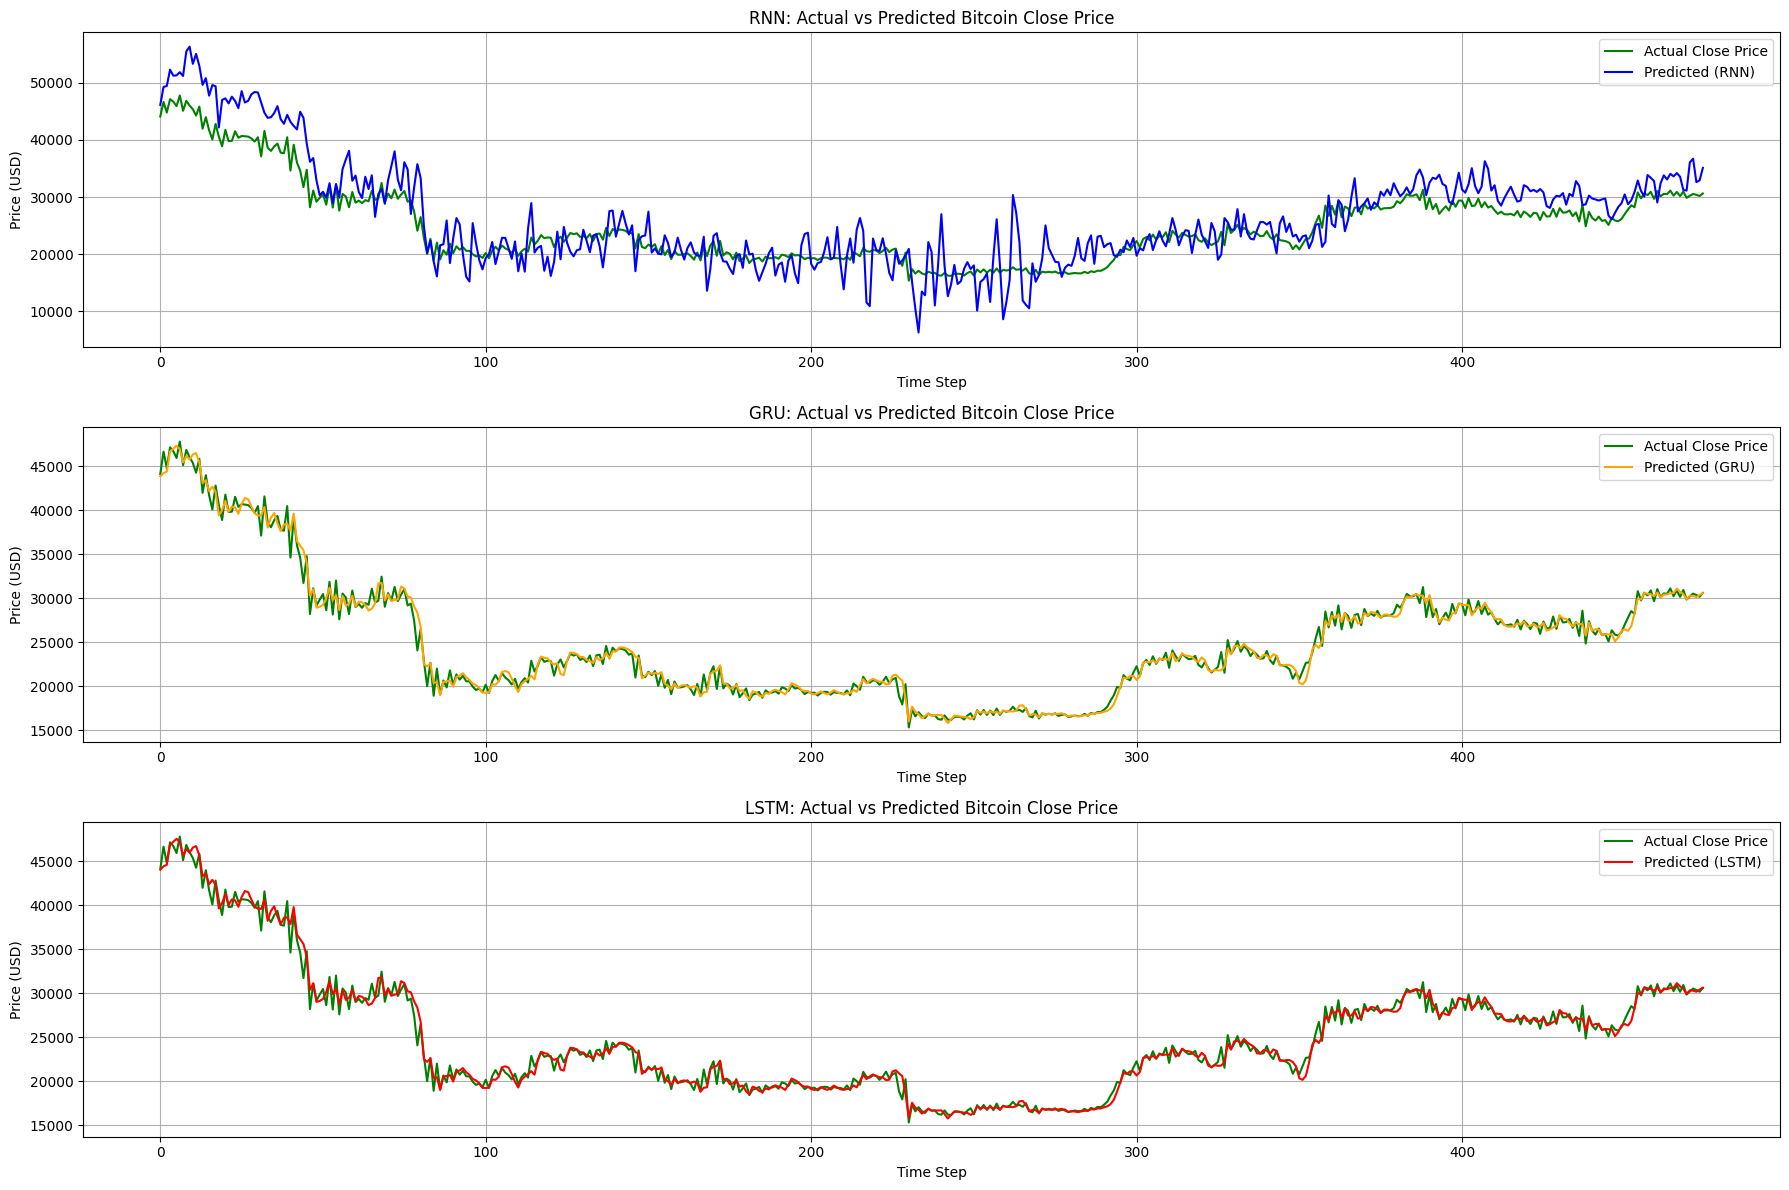

In [49]:
plt.figure(figsize=(18, 12))

# --- RNN ---
plt.subplot(3, 1, 1)
plt.plot(actual_close, label='Actual Close Price', color='green')
plt.plot(predicted_close_rnn, label='Predicted (RNN)', color='blue')
plt.title('RNN: Actual vs Predicted Bitcoin Close Price')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# --- GRU ---
plt.subplot(3, 1, 2)
plt.plot(actual_close, label='Actual Close Price', color='green')
plt.plot(predicted_close_gru, label='Predicted (GRU)', color='orange')
plt.title('GRU: Actual vs Predicted Bitcoin Close Price')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

# --- LSTM ---
plt.subplot(3, 1, 3)
plt.plot(actual_close, label='Actual Close Price', color='green')
plt.plot(predicted_close_lstm, label='Predicted (LSTM)', color='red')
plt.title('LSTM: Actual vs Predicted Bitcoin Close Price')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Error Trend

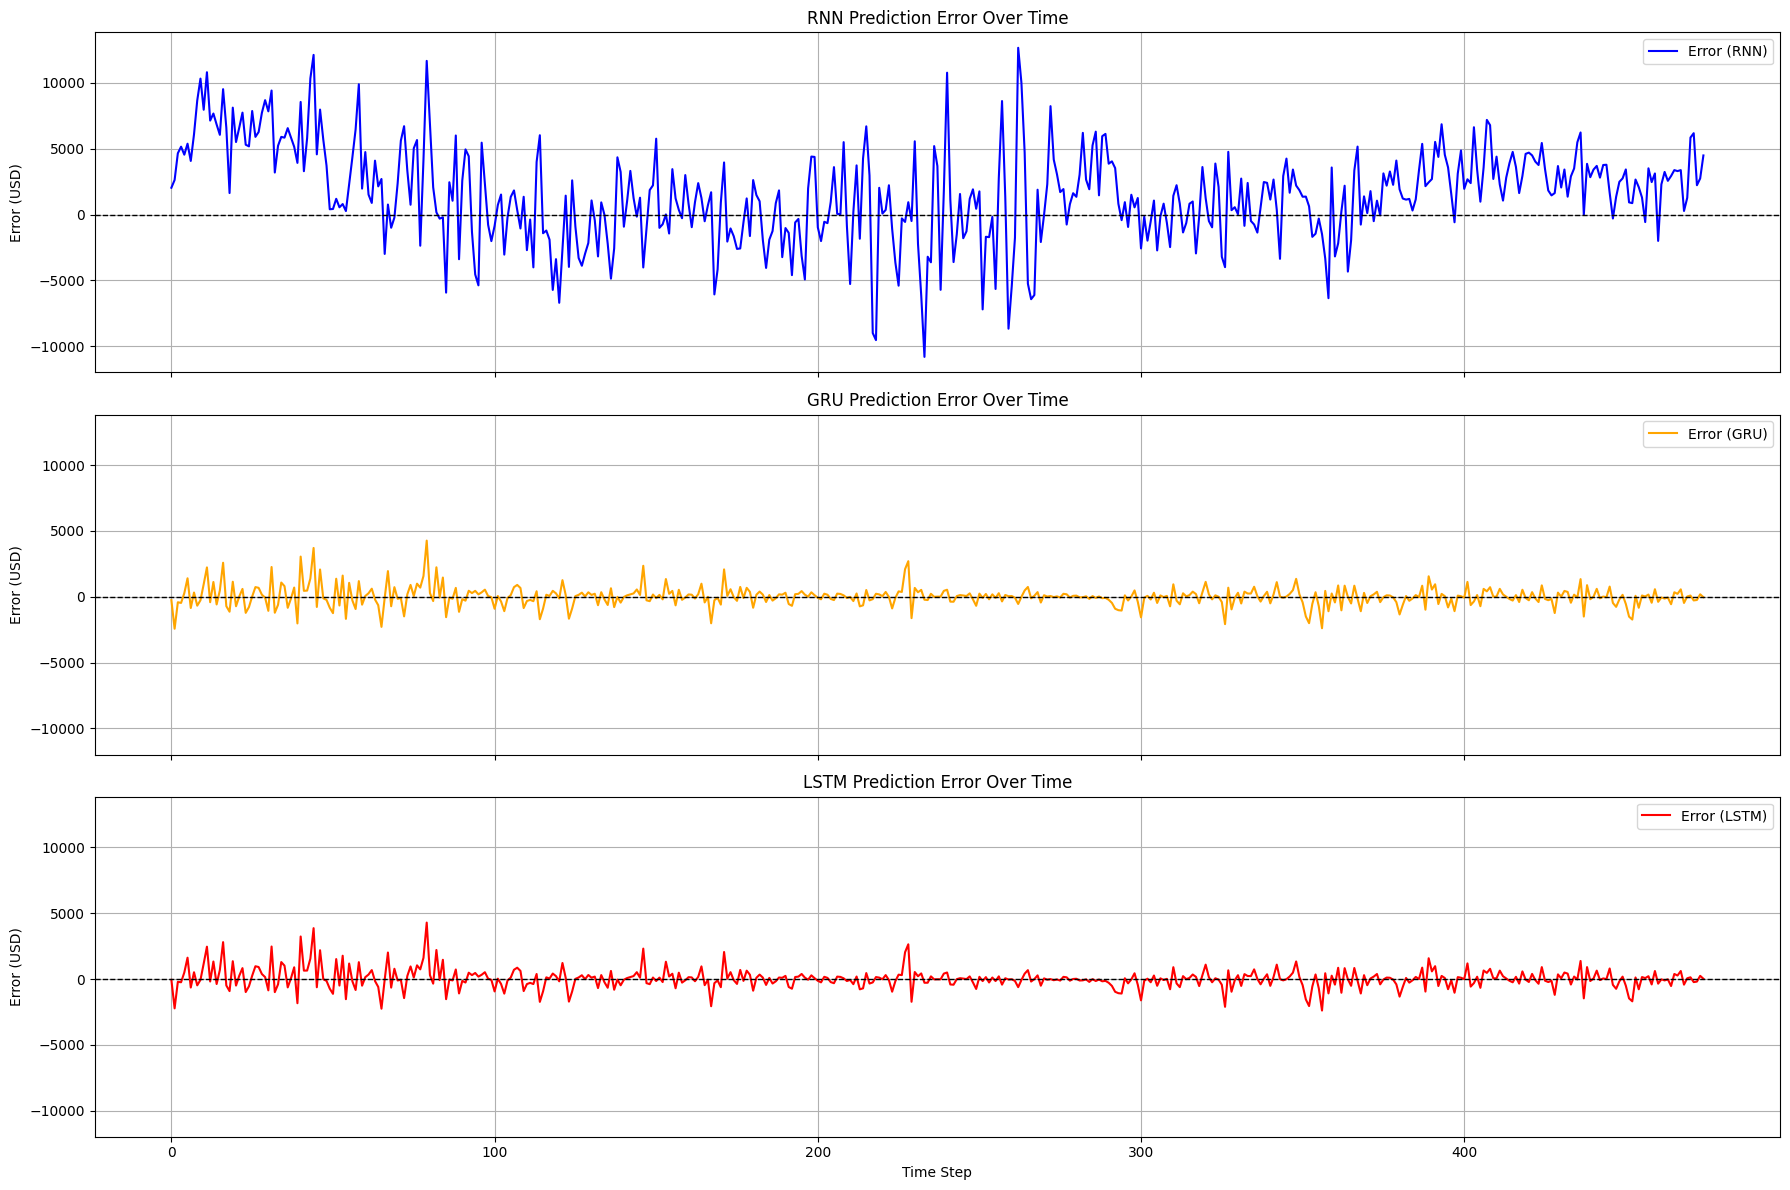

In [50]:
error_rnn = predicted_close_rnn - actual_close
error_gru = predicted_close_gru - actual_close
error_lstm = predicted_close_lstm - actual_close

fig, axs = plt.subplots(3, 1, figsize=(18, 12), sharex=True, sharey=True)

# --- RNN ---
axs[0].plot(error_rnn, color='blue', label='Error (RNN)')
axs[0].axhline(0, color='black', linestyle='--', linewidth=1)
axs[0].set_title('RNN Prediction Error Over Time')
axs[0].set_ylabel('Error (USD)')
axs[0].grid(True)
axs[0].legend()

# --- GRU ---
axs[1].plot(error_gru, color='orange', label='Error (GRU)')
axs[1].axhline(0, color='black', linestyle='--', linewidth=1)
axs[1].set_title('GRU Prediction Error Over Time')
axs[1].set_ylabel('Error (USD)')
axs[1].grid(True)
axs[1].legend()

# --- LSTM ---
axs[2].plot(error_lstm, color='red', label='Error (LSTM)')
axs[2].axhline(0, color='black', linestyle='--', linewidth=1)
axs[2].set_title('LSTM Prediction Error Over Time')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Error (USD)')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()